In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL

from mac0460_5832.utils import *

In [2]:
import pandas as pd
import pdb
from sklearn.metrics import precision_score, recall_score, f1_score
from time import time
from toolz import curry
from joblib import Parallel, delayed
from multiprocessing import cpu_count, Pool
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt

In [48]:
def find_center(a):
    """
    a: array
    """
    r = int(a.shape[0] / 2)
    c = int(a.shape[1] / 2)
    
    return (r, c)

def extract_window(image, W, stride=0):
    ### Zero Padding
    W_center = find_center(W)
    vertical_shift = (W.shape[0] - 1) - W_center[0]
    horizontal_shift = (W.shape[1] - 1) - W_center[1]
    pad_width = max([vertical_shift, horizontal_shift])
    im = np.pad(image, pad_width, mode="constant", constant_values=0)
    im = im * 1
        
    extracted = []
    for i in range(int(image.shape[0] / (stride + 1))):
        i += pad_width 
        i += i*stride
        for j in range(int(image.shape[1] / (stride + 1))):
            j += pad_width
            j += j*stride
            #pdb.set_trace()
            extracted.append((W * im[i-vertical_shift:i+vertical_shift+1, j-horizontal_shift:j+horizontal_shift+1]).astype(int))
                
    return extracted

def accuracy_score(y_true, y_pred):
    pairs = list(zip(y_true, y_pred))
    accuracies = [np.sum(pair[0] == pair[1]) / len(pair[0].flatten()) for pair in pairs]
    return np.mean(np.array(accuracies))

def mse_score(y_true, y_pred):
    pairs = list(zip(y_true, y_pred))
    mses = [np.mean(np.power(pair[0] - pair[1], 2)) for pair in pairs]
    return np.mean(np.array(mses))

    return 0

def first_array(x):
    return list(x[0])
    
def train_w(I, O, W_shape, operator=[], stride=0, verbose=True, multiproc=False):
    """
    I: list of input images
    O: list of output images
    W_shape: window shape
    """
    if len(operator) == 0:
        W = np.ones(W_shape)
    else:
        W = operator
        
    ###
    if multiproc:
        pass
    else:
        list_of_patterns = [extract_window(i.astype(int), W, stride) for i in I]
        X_train = [pattern for patterns in list_of_patterns for pattern in patterns]
        
        list_of_labels = [extract_window(o.astype(int), np.ones((1,1))) for o in O]
        y_train = [label for labels in list_of_labels for label in labels]
        
    ### Multiply X_train by W considering the 1s and 0s
#     if len(operator) == 0:
#         X_train = [pattern * operator for pattern in X_train]
        
    start = time()
    ### Fit
    df = pd.DataFrame()
    df["pattern"] = X_train
    df["array"] = X_train
    df["y"] = y_train
    df["y"] = df["y"].apply(lambda x : x[0][0])
    df["pattern"] = df["pattern"].apply(lambda x : str(x.astype(int)))    
    threshold = np.mean(y_train)
    f = df.groupby("pattern", as_index=False).agg({"y": "mean", "array": lambda x : list(x)})
    f["array"] = f["array"].apply(lambda x : x[0])
    
    
    f["y"] = (f["y"] > threshold) * 1 
    
    
    if verbose:
        print('Fitting: {0}m{1}s'.format(int((time()-start)/60), int((time()-start)%60 )))        
    
    start = time()
    ### Predict
    y_pred = [predict(f, im, W) for im in I]   
    if verbose:
        print('Predict: {0}m{1}s'.format(int((time()-start)/60), int((time()-start)%60 )))        
    
    ### Friendly format to calc the metrics
    y_true = [y[0][0] for y in y_train]
    y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]

    start = time()
    ### metrics to log
    accuracy = accuracy_score(O, y_pred)    
    precision = precision_score(y_true, y_hat)
    recall = recall_score(y_true, y_hat)
    mse = mse_score(O, y_pred)    
    f1 = f1_score(y_true, y_hat)
    if verbose:
        print('Metrics: {0}m{1}s'.format(int((time()-start)/60), int((time()-start)%60 )))        
    
    logs = {}
    logs["accuracy"] = accuracy
    logs["mse"] = mse    
    logs["precision"] = precision
    logs["recall"] = recall
    logs["f1"] = f1
    
    if verbose:
        print("Training metrics: ")
        print("Threshold: {:.2f}".format(threshold))
        print("Accuracy: {:0.2f}".format(accuracy))    
        print("Precision: {:0.2f}".format(precision))
        print("Recall: {:0.2f}".format(recall))
        print("MSE: {:0.2f}".format(mse))
        print("F1: {:0.2f}".format(f1))
    
    return X_train, y_train, f, logs

def learning_curve(I, O, W_shape, T, operator=[], stride=0, verbose=False, multiproc=False):
    
    train_errors = []
    test_errors = []
    for i in tqdm_notebook(range(1, len(I))):
        train_images = I[:i]
        train_output = O[:i]
        X_train, y_train, f, logs = train_w(train_images, train_output, w.shape, operator, verbose=verbose)
        
        train_errors.append(1 - logs["accuracy"])

        ### Test error
        y_pred = [predict(f, im, operator) for im in T]   
        y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]
        
        accuracy = accuracy_score(O, y_pred)
        test_errors.append(1 - accuracy)
        
    plt.plot(train_errors, label="Ein")
    plt.plot(test_errors, label="Eout")
    plt.title("Learning Curve")
    plt.xlabel("Number of training images")
    plt.ylabel("Percentage of incorrect predicted pixels")
    plt.legend()
    plt.show()
    
def learning_curve_multiresolution(I, O, windows, T, operator=[], stride=0, verbose=False, multiproc=False):
    train_errors = []
    test_errors = []
    for i in tqdm_notebook(range(0, len(I))):
        import pdb;pdb.set_trace()
        train_images = I[:i]
        train_output = O[:i]
        
        functions = []
        for window in windows:
            X_train, y_train, f, logs = train_w(train_images, train_output, window.shape, window, verbose=verbose)
            functions.append(f)
    
        y_pred = [multiresolution_predict(functions, im, windows) for im in train_images]   
        #y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]
        
        train_accuracy = accuracy_score(train_output, y_pred)
        if train_accuracy == np.nan:
            train_accuracy = 1
        train_errors.append(1 - train_accuracy)

        ### Test error
        y_pred = [multiresolution_predict(functions, im, windows) for im in T]   
        #y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]
        
        test_accuracy = accuracy_score(O[:len(T)], y_pred)
        test_errors.append(1 - test_accuracy)
        
    plt.plot([i for i in range(1, len(I)+1), train_errors, label="Ein")
    plt.plot([i for i in range(1, len(I)+1), test_errors, label="Eout")
    plt.title("Learning Curve")
    plt.xlabel("Number of training images")
    plt.ylabel("Percentage of incorrect predicted pixels")
    plt.legend()
    plt.show()
    
    return train_errors, test_errors
    
def retrieve_prediction(f, pattern):
    try:
        prediction = f[f["pattern"] == str(pattern)]["y"].values[0]
    except:
        prediction = 0
        
    return prediction
                        
def predict(f, image, W):
    """
    
    """
    extracted_feats = extract_window(image, W)    

    ### Multiproc
    partitions = cpu_count()
    result = Parallel(n_jobs= partitions, max_nbytes=None)(delayed(retrieve_prediction)(f, pattern) for pattern in extracted_feats)

    ### Single thread
    #result = [retrieve_prediction(f, feat) for feat in extracted_feats]    
    
    output = np.array(result).reshape(image.shape)
    
    return output

def multiresolution_predict(functions, image, windows):
    output = np.zeros(image.shape)
    result = []
    extracted_feats = [extract_window(image, W) for W in windows]
    
    for pixel in range(np.size(image)):
        prediction = None
        for i, function in enumerate(functions):
            try:
                prediction = function[function["pattern"] == str(extracted_feats[i][pixel])]["y"].values[0]                
                break
            except:
                pass
        if prediction == None:
            prediction = 0
        result.append(prediction)
                                      
    return np.array(result).reshape(image.shape)

def print_patterns(patterns):    
    for pattern in patterns:
        draw_img(pattern)
        
        
def custom_erosion(element, img):
    pass

def custom_dilatation(element, img):
    pass

# MAC0460/5832 - Lista 2: Escolha de modelo

### Data de Entrega: 23h55m do dia 22/10/2018

(Ainda sem monitoria definida)

Q1. Projete, a partir dos dados, o operador capaz de filtrar ruído usando a técnica de multiresolução. Como conjuntos de hipóteses, utilize diferentes subamostragens da janela original, como ilustrado abaixo:

1. Subamostragem 1: ![alt text](imgs/q1_h1.png "1")
2. Subamostragem 2: ![alt text](imgs/q1_h2.png "2")
3. Subamostragem 3: ![alt text](imgs/q1_h3.png "2")

Para cada conjunto, plote os erros  $E_{in}$ e $E_{val}$ ao longo do treinamento. Após escolher o modelo mais apropriado, retreine seu operador com todos os dados e imprima o erro $E_{in}$.

Utilize as imagens da pasta imgs/q1/ para realizar o treinamento e validação (nota: são as mesmas imagens do EP anterior).

In [4]:
n_train = 10
train_images = [read_img("imgs/q1/q1_src" + str(i) + ".png") for i in range(1, n_train+1)]
train_output = [read_img("imgs/q1/q1_dest.png") for i in range(1, n_train+1)]

In [11]:
train_images[:1]

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])]

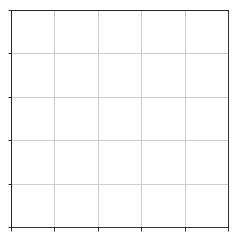

In [5]:
w1 = np.ones((3, 3), dtype=int)
w1 = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1] , [1, 1, 1, 1, 1]])
draw_img(w1)

### Deveria aparecer todo escuro, mas quando é tudo 1 ele fica branco.
### Se eu tiro um 1 e substituo por 0 ele fica com todos em preto, 
### menos um.

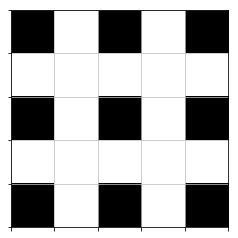

In [6]:
w2 = np.array([[1, 0, 1, 0, 1], [0, 0, 0, 0, 0], [1, 0, 1, 0, 1], [0, 0, 0, 0, 0] , [1, 0, 1, 0, 1]])
draw_img(w2)

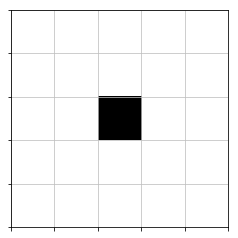

In [7]:
w3 = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0] , [0, 0, 0, 0, 0]])
draw_img(w3)

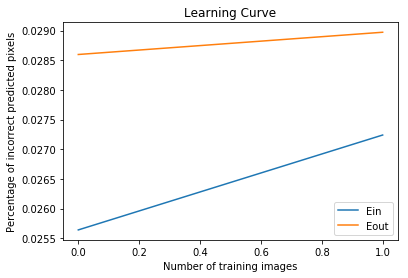

([0.025640624999999972, 0.027240234375000005],
 [0.028597656249999992, 0.028972656250000006])

In [8]:
windows = [w1, w2, w3]

ein_1, eout_1 = learning_curve_multiresolution(train_images[:4], train_output[:4], windows, train_images[9:], operator=[], stride=0, verbose=False, multiproc=False)

In [49]:
train_images = [read_img("imgs/q1/q1_src" + str(i) + ".png") for i in range(1, n_train+1)]
train_output = [read_img("imgs/q1/q1_dest.png") for i in range(1, n_train+1)]

In [50]:
train_images[0].shape

(400, 640)

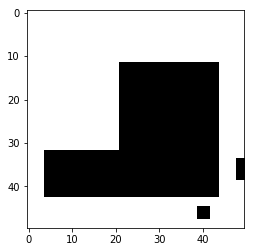

In [51]:
draw_img(train_images[0][150:200, 150:200])

In [52]:
train_images = [im[150:300, 150:300] for im in train_images]
train_output = [im[150:300, 150:300] for im in train_output]

/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/site-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


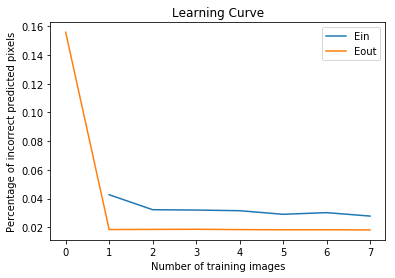

In [53]:
windows = [w1, w2, w3]

ein_1, eout_1 = learning_curve_multiresolution(train_images[:8], train_output[:8], windows, train_images[8:], operator=[], stride=0, verbose=False, multiproc=False)

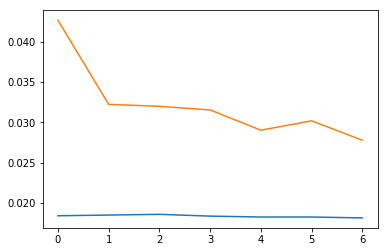

In [58]:
plt.plot(eout_1[1:])
plt.plot(ein_1[1:])

In [ ]:
windows = [w1, w2, w3]

ein_2, eout_2 = learning_curve_multiresolution(train_images[:3], train_output[:3], windows, train_images[9:], operator=[], stride=0, verbose=False, multiproc=False)

In [ ]:
windows = [w1, w2, w3]

ein_3, eout_3 = learning_curve_multiresolution(train_images[:3], train_output[:3], windows, train_images[9:], operator=[], stride=0, verbose=False, multiproc=False)

Q2. Considere novamente o problema de filtrar ruído. Utilizando as imagens da pasta imgs/q2/, explore diferentes funções booleanas para filtrar ruído. A operação **abertura** é definida como uma **erosão** seguida por uma **dilatação**, isto é $\delta_{B2}\epsilon_{B1}$, onde $B1$ e $B2$ são os elementos estruturantes. De modo semelhante, a função **fechamento** é definida por uma **dilatação** seguida por uma **erosão** ($\epsilon_{B2}\delta_{B1}$). Baseado nas funções *erosion* e *dilation* definidas em mac0460_5832/utils.py, teste os seguintes espaços de hipóteses:

1. Abertura;
2. Fechamento;
3. Abertura seguida de fechamento;

Para cada espaço de hipóteses, defina diferentes funções variando $B1$ e $B2$ (ou seja, crie as funções de maneira análoga à seguinte definição para um conjunto de aberturas: $\mathcal{F} = \{\psi_{B1B2}: \psi =  \delta_{B2}\epsilon_{B1}, B1, B2 \subseteq W_{3x3} \}$, onde $W_{3x3}$ é a janela 3x3). Mostre a função que tem menor erro e verifique o seu desempenho nos dados de teste.

Obs: existe no utils.py funções para abertura e fechamento. No entanto, essas funções utilizam o mesmo elemento estruturante para a erosão e dilatação, não permitindo o uso de diferentes elementos estruturantes. 

### Resolução

1. Definir os elementos estruturantes (kernel) possíveis a serem usados como B1 e B2
2. Testar os 3 espaços de hipótese com todas as combinações de B1 e B2
3. Selecionar o que apresentar o menor erro e aplicar em uma imagem não usada no cálculo deste (uma de teste)

In [70]:
w1 = np.ones((3,3), dtype=np.uint8)
w2 = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
w3 = np.array([[0, 1, 1], [1, 1, 1], [1, 1, 0]], dtype=np.uint8)
w4 = np.array([[1, 1, 1], [0, 1, 0], [1, 1, 1]], dtype=np.uint8)
w5 = np.array([[1, 0, 1], [1, 0, 1], [0, 0, 1]], dtype=np.uint8)

bs = [w1, w2, w3, w4, w5]

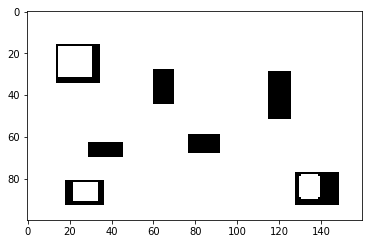

In [69]:
import cv2
import numpy as np

img = cv2.imread('imgs/q2/src0.png',0)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img, w1, iterations = 3)
draw_img(erosion)

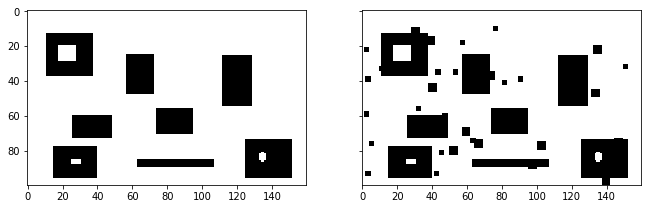

In [2]:
# Exemplo 
draw_img_pair(read_img('imgs/q2/dest.png'), read_img('imgs/q2/src0.png'), figsz=(11, 3.5))